# (a) RNN+SGD+50d

In [45]:
import numpy as np
from emo_utils import *

# glove 데이터 얻어오는 부분
glove_50d_path = "glove_file/glove.6b.50d.txt"
#glove_100d_path = "glove_file/glove.6b.100d.txt"

words_to_index_50d, index_to_words_50d, word_to_vec_map_50d = read_glove_vecs(glove_50d_path)
#words_to_index_100d, index_to_words_100d, word_to_vec_map_100d = read_glove_vecs(glove_100d_path)

# test data와 train data 얻어오는 부분
test_phase, test_emoji = read_csv('test_emoji.csv')
train_phase, train_emoji = read_csv('train_emoji.csv')

# emoji를 one-hot encoding하기
train_true = np.eye(5)[train_emoji]  # 5*132
test_true = np.eye(5)[test_emoji]   # 5*52


In [46]:
def padding_and_embedding(sentences, word_to_vec_map, max_len=10, embedding_dim=50):
    batch = len(sentences)
    embedded_sentences = np.zeros((batch,max_len,embedding_dim))
    padding_mask = np.zeros((batch, max_len))

    for i, sentence in enumerate(sentences):
        words = sentence.lower().split()

        for j, word in enumerate(words[:max_len]):
            if word in word_to_vec_map:
                embedded_sentences[i,j] = word_to_vec_map[word]
                padding_mask[i, j] = 1
    return embedded_sentences, padding_mask

# 50d로 embedding하기
train_embeddings, train_padding_mask = padding_and_embedding(train_phase, word_to_vec_map_50d)
test_embeddings, test_padding_mask = padding_and_embedding(test_phase, word_to_vec_map_50d)

In [47]:
def clip_gradient(grad, max_grad_norm=1.0):
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_grad_norm:
        grad = grad * (max_grad_norm / grad_norm)
    return grad

In [48]:
class rnn_cell():
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        self.waa = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2 / (hidden_dim))
        self.wxa = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / (input_dim))
        self.way = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / (hidden_dim))
        self.ba = np.random.randn(1, hidden_dim) * np.sqrt(1 / hidden_dim)
        self.by = np.random.randn(1, output_dim) * np.sqrt(1 / output_dim)

        self.dwaa = np.zeros_like(self.waa)
        self.dwax = np.zeros_like(self.wxa)
        self.dway = np.zeros_like(self.way)
        self.dba = np.zeros_like(self.ba)
        self.dby = np.zeros_like(self.by)


    def forward(self, x):
        batch_size, time_steps, input_dim = x.shape
        hidden_dim = self.waa.shape[0]
        self.hidden_states = np.zeros((batch_size, time_steps, hidden_dim))
        outputs = np.zeros((batch_size, time_steps, self.way.shape[1]))
        self.x=x
        self.a_prev = np.zeros((batch_size, hidden_dim))
        for t in range(time_steps):
            self.x_t = x[:,t,:]
            self.a_next = np.tanh(np.dot(self.a_prev, self.waa) + np.dot(self.x_t, self.wxa) + self.ba)     
            
            self.y_t = np.dot(self.a_next, self.way) + self.by
            
            self.hidden_states[:,t,:] = self.a_next
            outputs[:,t,:] = self.y_t
            self.a_prev = self.a_next
        return outputs
    
    def backward_rnn2(self, dy_last):
        batch_size, hidden_dim = dy_last.shape
        time_steps = self.hidden_states.shape[1]
        input_dim = self.wxa.shape[0]

        dx = np.zeros((batch_size, time_steps, input_dim))
        da_next = np.zeros((batch_size, hidden_dim))
        for t in reversed(range(time_steps)):
            dy_t = dy_last if t == time_steps - 1 else np.zeros_like(dy_last)
            if t==time_steps-1:
                self.dway += np.dot(self.hidden_states[:, t, :].T, dy_t)
                self.dby += np.sum(dy_t, axis=0, keepdims=True)
                da = np.dot(dy_t, self.way.T) + da_next
            else:
                da = da_next
            dz = da * (1 - self.hidden_states[:, t, :] ** 2)
            # dz= np.clip(dz,-1,1)
            dz = clip_gradient(dz)
            if t > 0:
                self.dwaa += np.dot(self.hidden_states[:, t - 1, :].T, dz)
            self.dwax += np.dot(self.x[:, t, :].T, dz)
            self.dba += np.sum(dz, axis=0, keepdims=True)

            dx[:,t,:] = np.dot(dz, self.wxa.T)

            da_next = np.dot(dz,self.waa.T)
        return dx
    
    
    def backward_rnn1(self, dy_last):

        batch_size, time_steps, hidden_dim = dy_last.shape
        input_dim = self.wxa.shape[0]

        dx = np.zeros((batch_size, time_steps, input_dim))
        da_next = np.zeros((batch_size, hidden_dim))
        for t in reversed(range(time_steps)):
            dy_t = dy_last[:,t,:] if t == time_steps - 1 else np.zeros_like(dy_last[:,t,:])
            self.dway += np.dot(self.hidden_states[:, t, :].T, dy_t)
            self.dby += np.sum(dy_t, axis=0, keepdims=True)
            da = np.dot(dy_t, self.way.T) + da_next
            dz = da * (1 - self.hidden_states[:, t, :] ** 2)
            dz= np.clip(dz,-1,1)

            if t > 0:
                self.dwaa += np.dot(self.hidden_states[:, t - 1, :].T, dz)
            self.dwax += np.dot(self.x[:, t, :].T, dz)
            self.dba += np.sum(dz, axis=0, keepdims=True)

            dx[:,t,:] = np.dot(dz, self.wxa.T)

            da_next = np.dot(dz,self.waa.T)
        return dx

In [49]:
class linear:
    def __init__(self, learning_rate, input_size, output_size=5):
        self.learning_rate = learning_rate
        self.weight = np.random.randn(input_size, output_size) * np.sqrt(1 / (input_size)) 
        self.bias = np.random.randn(1, output_size)* np.sqrt(1 / (output_size)) 

    def forward(self, input):   
        self.input = input  # Backpropagation을 위해 저장
        return np.dot(input, self.weight) + self.bias

    def backward(self, output_gradient):
        # Compute gradients for weights and biases
        self.dweight = np.dot(self.input.T, output_gradient)
        self.dbias = np.sum(output_gradient, axis=0, keepdims=True)
        # Compute gradient for the input
        input_gradient = np.dot(output_gradient, self.weight.T)  # (batch_size, input_size)
        return input_gradient

In [50]:
class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, x, is_training=True):
        if not is_training:
            return x  # Dropout 비활성화
        self.mask = (np.random.rand(*x.shape) < self.keep_prob) / self.keep_prob
        return x * self.mask
    
    def backward(self, grad_output):
        grad_output = clip_gradient(grad_output)
        return grad_output * self.mask

In [51]:
class RNNNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, keep_prob, learning_rate):
        # LSTM Layers
        self.rnn1 = rnn_cell(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
        self.dropout1 = Dropout(keep_prob=keep_prob)
        self.rnn2 = rnn_cell(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
        self.dropout2 = Dropout(keep_prob=keep_prob)
        self.linear = linear(learning_rate=learning_rate, input_size=hidden_dim, output_size=output_dim)
        
    def forward(self, x, is_training=True):
        self.inputs = [None] * 5
        
        self.inputs[0] = self.rnn1.forward(x)  # Output shape: (batch_size, time_steps, hidden_dim)
        self.inputs[1] = self.dropout1.forward(self.inputs[0], is_training)  # Shape: (batch_size, time_steps, hidden_dim)
        self.inputs[2] = self.rnn2.forward(self.inputs[1])[:, -1, :]  # Shape: (batch_size, hidden_dim)
        self.inputs[3] = self.dropout2.forward(self.inputs[2], is_training)  # Shape: (batch_size, hidden_dim)
        self.inputs[4] = self.linear.forward(self.inputs[3])  # Shape: (batch_size, output_dim)
        return self.inputs[4]
    
    def backward(self, output_gradient):

        grad = self.linear.backward(output_gradient)  # Shape: (batch_size, hidden_dim)
        grad = self.dropout2.backward(grad)  # Shape: (batch_size, hidden_dim)
        grad = self.rnn2.backward_rnn2(grad)  # Shape: (batch_size, time_steps, hidden_dim)
        grad = self.dropout1.backward(grad)  # Shape: (batch_size, time_steps, hidden_dim)
        dx = self.rnn1.backward_rnn1(grad)  # Shape: (batch_size, time_steps, input_dim) 
        return dx


In [52]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, param, grad):
        return param - self.learning_rate * grad

In [53]:
def SoftMax(output):  # channel, 5
    output -= np.max(output, axis=1, keepdims=True)
    # output = np.clip(output, -1, 1)
    exp_output = np.exp(output)
    softmax_values = exp_output / np.sum(exp_output, axis=1, keepdims=True)
    return softmax_values

class CE_Loss():
    def forward(self, y_pred, y_true):  # (batch_size, 5)
        y_pred = np.clip(y_pred, 1e-15, 1-1e-15)  # log값이 0이 되어 발산하는 거 방지
        loss = -np.sum(y_true*np.log(y_pred), axis=1)
        return np.mean(loss)  # 그냥 loss 출력해도 되지만 epoch당 loss를 알아보기 위해서
    
    def backward(self, y_pred, y_true):
        return y_pred-y_true

In [54]:
def RNN_train(model, x_train, y_train, batch_size, train_loss, learning_rate):
    optimizer = SGD(learning_rate)
    num_iters = x_train.shape[0] //batch_size
    # indices = np.random.rand(x_train.shape[0])
    tmp_loss=[]

    for i in range(num_iters):
        x_batch = x_train[i*batch_size:(i+1)*batch_size,:,:]
        y_batch = y_train[i*batch_size:(i+1)*batch_size,:]

        output = model.forward(x_batch, is_training=True)

        y_pred = SoftMax(output)

        loss_fn = CE_Loss()
        loss = loss_fn.forward(y_pred, y_batch)
        tmp_loss.append(loss)

        output_gradient = loss_fn.backward(y_pred, y_batch)
        model.backward(output_gradient)

        model.linear.weight = optimizer.update(model.linear.weight, model.linear.dweight)
        model.linear.bias = optimizer.update(model.linear.bias, model.linear.dbias)

        # Update weights of rnn2
        model.rnn2.waa = optimizer.update(model.rnn2.waa, model.rnn2.dwaa)
        model.rnn2.wxa = optimizer.update(model.rnn2.wxa, model.rnn2.dwax)
        model.rnn2.ba = optimizer.update(model.rnn2.ba, model.rnn2.dba)
        model.rnn2.way = optimizer.update(model.rnn2.way, model.rnn2.dway)
        model.rnn2.by = optimizer.update(model.rnn2.by, model.rnn2.dby)

        # Update weights of rnn1
        model.rnn1.waa = optimizer.update(model.rnn1.waa, model.rnn1.dwaa)
        model.rnn1.wxa = optimizer.update(model.rnn1.wxa, model.rnn1.dwax)
        model.rnn1.ba = optimizer.update(model.rnn1.ba, model.rnn1.dba)
        model.rnn1.way = optimizer.update(model.rnn1.way, model.rnn1.dway)
        model.rnn1.by = optimizer.update(model.rnn1.by, model.rnn1.dby)
    train_loss.append(sum(tmp_loss)/len(tmp_loss))
    return train_loss

def RNN_test(model, x_test, y_test, batch_size, test_loss, acc_lst):
    num_samples = x_test.shape[0]
    num_batches = num_samples // batch_size
    accuracy_list = []
    tmp_loss = []

    for i in range(num_batches):
        x_batch = x_test[i*batch_size:(i+1)*batch_size,:,:]
        y_batch = y_test[i*batch_size:(i+1)*batch_size,:]

        y_pred = SoftMax(model.forward(x_batch, is_training=False))

        loss_fn = CE_Loss()
        loss = loss_fn.forward(y_pred, y_batch)
        tmp_loss.append(loss)

        correct_count = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
        accuracy = correct_count / batch_size
        accuracy_list.append(accuracy)

    avg_loss = sum(tmp_loss) / len(tmp_loss)
    test_loss.append(avg_loss)
    acc_lst.append(sum(accuracy_list)/len(accuracy_list))

    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    return average_accuracy


In [71]:
# Import required libraries and modules
import numpy as np

# Hyperparameters
input_dim = 50         # Input dimension from embedding layer
hidden_dim = 128       # Hidden state dimension
output_dim = 5         # Number of output classes 
keep_prob = 1.0        # Dropout 유지 비율(1이면 dropout 안함)
batch_size = 50        
epochs = 40            

initial_learning_rate = 0.001
decay_rate = 0.05

model = RNNNetwork(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, keep_prob=keep_prob,learning_rate=initial_learning_rate)

train_loss = []  
test_loss = []   
acc_lst=[]

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}", end=" ")
    #learning_rate = initial_learning_rate / (1 + decay_rate * epochs)
    RNN_train(
        model=model,
        x_train=train_embeddings,
        y_train=train_true,
        batch_size=batch_size,
        train_loss=train_loss,
        learning_rate=initial_learning_rate
    )
    print(f"Training Loss: {train_loss[-1]:.4f}", end=" ")

    test_accuracy = RNN_test(
        model=model,
        x_test=test_embeddings,
        y_test=test_true,
        batch_size=batch_size,
        test_loss=test_loss,
        acc_lst=acc_lst
    )
    print(f"Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Test Loss: {test_loss[-1]:.4f}, Final Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/40 Training Loss: 2.1642 Test Loss: 1.8376, Test Accuracy: 12.00%
Epoch 2/40 Training Loss: 1.6999 Test Loss: 1.7481, Test Accuracy: 24.00%
Epoch 3/40 Training Loss: 1.3539 Test Loss: 1.6802, Test Accuracy: 22.00%
Epoch 4/40 Training Loss: 1.1063 Test Loss: 1.6092, Test Accuracy: 28.00%
Epoch 5/40 Training Loss: 0.9089 Test Loss: 1.6028, Test Accuracy: 34.00%
Epoch 6/40 Training Loss: 0.7097 Test Loss: 1.6446, Test Accuracy: 34.00%
Epoch 7/40 Training Loss: 0.5383 Test Loss: 1.7242, Test Accuracy: 32.00%
Epoch 8/40 Training Loss: 0.3839 Test Loss: 1.8211, Test Accuracy: 32.00%
Epoch 9/40 Training Loss: 0.2615 Test Loss: 1.9332, Test Accuracy: 34.00%
Epoch 10/40 Training Loss: 0.1660 Test Loss: 2.0269, Test Accuracy: 34.00%
Epoch 11/40 Training Loss: 0.1016 Test Loss: 2.0600, Test Accuracy: 34.00%
Epoch 12/40 Training Loss: 0.0590 Test Loss: 2.1051, Test Accuracy: 38.00%
Epoch 13/40 Training Loss: 0.0272 Test Loss: 2.2508, Test Accuracy: 38.00%
Epoch 14/40 Training Loss: 0.0130 

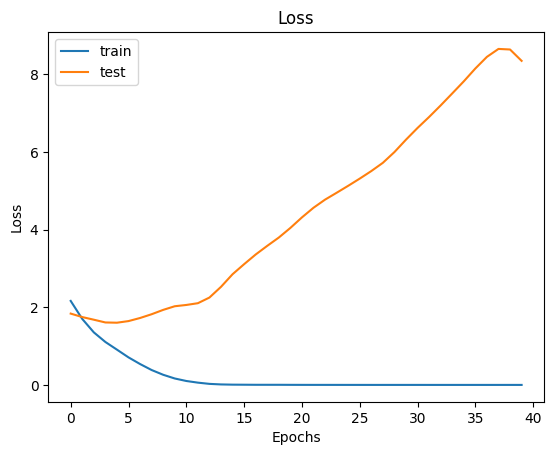

In [72]:
import matplotlib.pyplot as plt
# loss 그래프
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

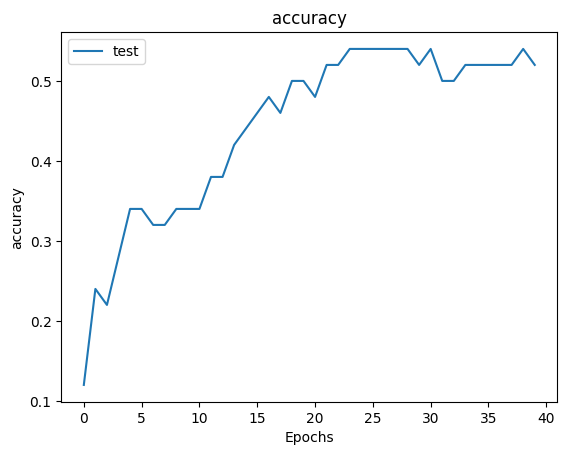

In [73]:
plt.plot(acc_lst, label='test')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [70]:
from emo_utils import *

def LSTM_predict(model, x_test):
    y_pred = SoftMax(model.forward(x_test, is_training=False))
    return y_pred

y_pred = LSTM_predict(model, test_embeddings)
predicted_classes = np.argmax(y_pred, axis=1)

print("정답(1~26): ",end="")
for i in range(0,len(test_embeddings)//2):
    print(label_to_emoji(test_emoji[i]), end="")
print()
print("예측(1~26): ",end="")
for i in range(0,len(test_embeddings)//2):
    print(label_to_emoji(predicted_classes[i]), end="")
print()
print()
print("정답(27~52): ",end="")
for i in range(len(test_embeddings)//2,len(test_embeddings)):
    print(label_to_emoji(test_emoji[i]), end="")
print()
print("예측(27~52): ",end="")
for i in range(len(test_embeddings)//2,len(test_embeddings)):
    print(label_to_emoji(predicted_classes[i]), end="")


정답(1~26): 🍴😞😄😄😄😄😞😄🍴😄⚾😞😞😞⚾😞😞😄😞🍴❤️😄🍴😞😞😞⚾❤️
예측(1~26): ⚾😞😄⚾😄😞⚾❤️😞😄😄❤️😞⚾⚾😄😄⚾⚾😞⚾⚾🍴😄😞⚾⚾😞

정답(27~52): ⚾😄❤️⚾😞😄😄⚾😄🍴🍴😄⚾❤️❤️⚾😄❤️😄😄😞😞😞❤️😞😄😄🍴
예측(27~52): ⚾⚾😄😞😞😄😞⚾⚾❤️⚾😄⚾❤️❤️⚾😞😞⚾😄😞⚾😞😄😞😄😞😞